In [1]:
import time
import os 
import numpy as np
from scipy import sparse
import pandas as pd
import h5py
import anndata
import matplotlib.pyplot as plt
import itertools

from dredFISH.Utils import basicu
from dredFISH.Utils.__init__plots import *

In [2]:
ddir = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/'
res_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/'

In [3]:
# read in data
f = os.path.join(ddir, 'scrna_ss_ctxhippo_a_exon_count_matrix_v5.h5ad')
adata = anndata.read(f)

# get the NN genes
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/10X/genes.npy' 
tenx_genes = np.load(f)
nn_genes = tenx_genes

# select nn genes only
nn_genes_idx = basicu.get_index_from_array(adata.var.index.values, nn_genes)
assert (nn_genes_idx == -1).sum() == 0
adata_nng = adata[:,adata.var.iloc[nn_genes_idx].index].copy()

In [4]:
# coverage norm
cov = np.asarray(adata.X.sum(axis=1)).flatten()
medcov = np.median(cov)
covscale = cov/medcov

adata_nng.layers['norm'] = adata_nng.X.toarray()/covscale.reshape(-1,1)


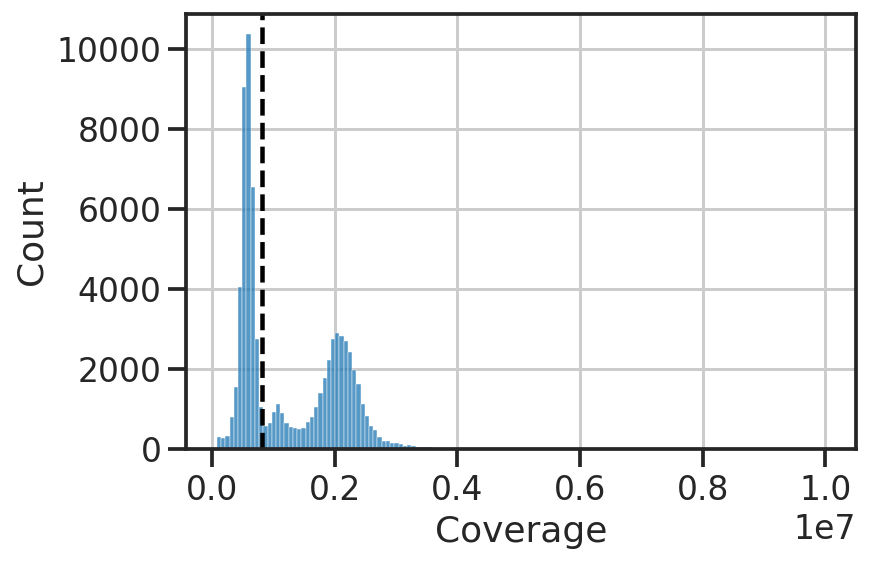

In [5]:
fig, ax = plt.subplots()
ax.set_xlabel('Coverage')
sns.histplot(cov, ax=ax)
ax.axvline(medcov, color='k', linestyle='--')
plt.show()

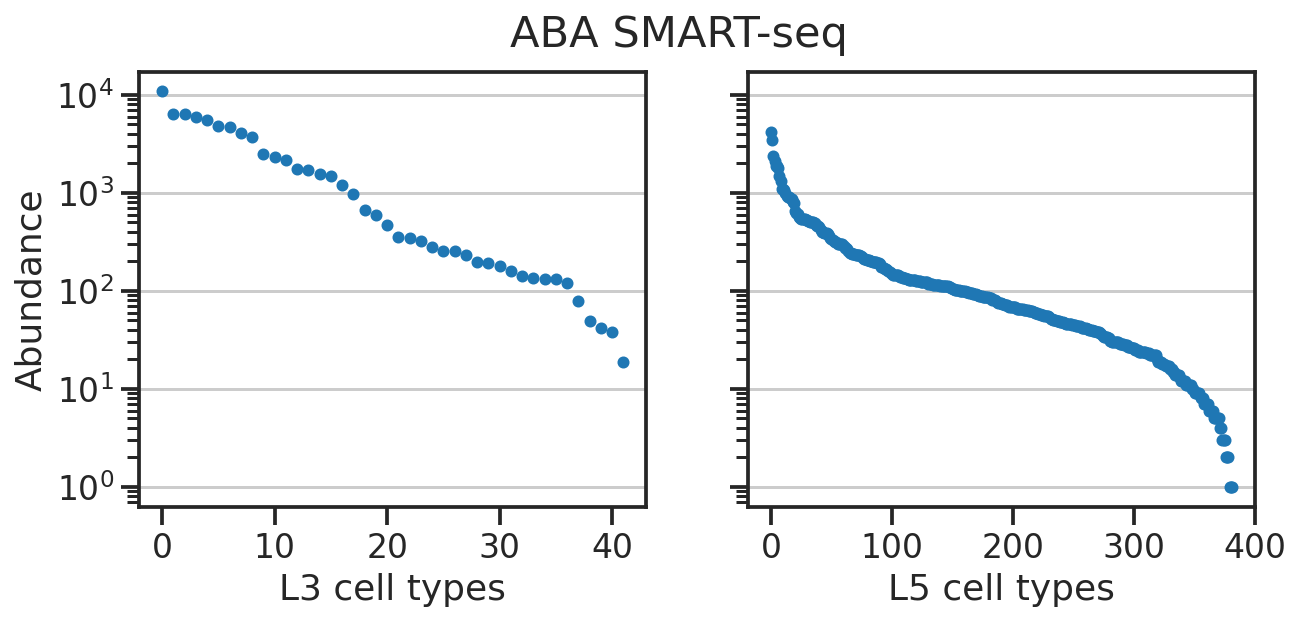

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(5*2,4), sharey=True)
ax = axs[0]
ax.plot(adata_nng.obs['subclass_label'].value_counts().values, 'o', markersize=5)
ax.grid(False, axis='x')
ax.set_yscale('log')
ax.set_xlabel('L3 cell types')
ax.set_ylabel('Abundance')

ax = axs[1]
ax.plot(adata_nng.obs['cluster_label'].value_counts().values, 'o', markersize=5)
ax.grid(False, axis='x')
ax.set_yscale('log')
ax.set_xlabel('L5 cell types')
# ax.set_ylabel('Abundance')
fig.suptitle('ABA SMART-seq')
plt.show()

In [7]:
ns = [
    # 10, 
    100, 
    # 1000,
]
cols = {
    # 'L3': 'subclass_label', 
    'L5': 'cluster_label',
    }
name0s = ['smrt_withrep_glut', 'smrt_withrep_gaba', 'smrt_withrep_nonn']

configs = []
# get all combinations
for name0, n, colkey in itertools.product(name0s, ns, cols.keys()):
    clstcol = cols[colkey]
    # name0, namex, namey, n, clstcol
    config = (name0, f'sub{colkey}n{n}', colkey, n, clstcol)
    configs.append(config)
    
configs

[('smrt_withrep_glut', 'subL5n100', 'L5', 100, 'cluster_label'),
 ('smrt_withrep_gaba', 'subL5n100', 'L5', 100, 'cluster_label'),
 ('smrt_withrep_nonn', 'subL5n100', 'L5', 100, 'cluster_label')]

In [8]:
print(adata_nng.obs['class_label'].unique())
adata_dict = {
    'smrt_withrep_glut': adata_nng[adata_nng.obs['class_label']=='Glutamatergic'],
    'smrt_withrep_gaba': adata_nng[adata_nng.obs['class_label']=='GABAergic'],
    'smrt_withrep_nonn': adata_nng[adata_nng.obs['class_label']=='Non-Neuronal'],
}
for key, item in adata_dict.items():
    print(key, len(item))

['Glutamatergic', 'GABAergic', 'Non-Neuronal']
Categories (3, object): ['GABAergic', 'Glutamatergic', 'Non-Neuronal']
smrt_withrep_glut 48796
smrt_withrep_gaba 22723
smrt_withrep_nonn 1828


In [9]:
for config in configs:
    print(config)
    name0, namex, namey, n, clstcol = config
    
    adata_sel = adata_dict[name0]
    # # randomly select cells L3 (does not allow oversamp)
    # dfsub, idxsub = basicu.stratified_sample(adata_nng.obs, clstcol, n, 
    #                                          return_idx=True, group_keys=False, sort=False, 
    #                                          random_state=0, 
    #                                         )
    
    # randomly select cells L5 (allow oversample)
    dfsub, idxsub = basicu.stratified_sample_withrep(adata_sel.obs, clstcol, n, 
                                             return_idx=True, group_keys=False, sort=False, 
                                             random_state=0, 
                                            )
    adatasub = adata_sel[adata_sel.obs.iloc[idxsub].index].copy()
    

    # convert to dense and format it; need the matrix and the labels
    Xcell = adatasub.obs.index.values
    # X = adatasub.X.toarray().T
    X = adatasub.layers['norm'].T # normalized counts
    y = adatasub.obs[clstcol].values

    # output
    out_Xcell = os.path.join(res_dir, f'{name0}_X_{namex}_cells.csv') 
    out_X = os.path.join(res_dir, f'{name0}_X_{namex}.npy') 
    out_y = os.path.join(res_dir, f'{name0}_X_{namex}_y_{namey}.npy') 
    
    pd.DataFrame(Xcell).to_csv(out_Xcell)
    np.save(out_X, X)
    np.save(out_y, y)
    

('smrt_withrep_glut', 'subL5n100', 'L5', 100, 'cluster_label')


/home/fangming/anaconda3/envs/torchgpu/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


('smrt_withrep_gaba', 'subL5n100', 'L5', 100, 'cluster_label')


/home/fangming/anaconda3/envs/torchgpu/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


('smrt_withrep_nonn', 'subL5n100', 'L5', 100, 'cluster_label')


/home/fangming/anaconda3/envs/torchgpu/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
